In [1]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Data Loading and Preprocessing

I start by loading the dataset from the provided CSV file `MergeConflictsDataset.csv`.

After loading:
- We check the initial shape of the dataset to understand how many samples and features it contains.
- We remove any rows containing missing values (`NaN`) to ensure model training will not fail due to incomplete data.
- We confirm the new shape of the cleaned dataset.

In [56]:
df = pd.read_csv('MergeConflictsDataset.csv', sep=';')
print(f"Dataset shape: {df.shape}")

Dataset shape: (26973, 37)


In [57]:
# Drop rows with missing values
df = df.dropna()

print(f"New dataset shape after dropping missing rows: {df.shape}")

New dataset shape after dropping missing rows: (26972, 37)


In [58]:
df.head()

,commit,parent1,parent2,ancestor,is pr,added lines,deleted lines,devs parent1,devs parent2,time,...,add,remove,use,delete,change,messages_min,messages_max,messages_mean,messages_median,conflict
0,efc0bcd1d6199448c323549fdc45310750b48c85,fb9f2a65cabba5a924b89a45793914066471b2ab,5ee7c7c750e9ecffaea12f97d5b05b2445e7c007,fb9f2a65cabba5a924b89a45793914066471b2ab,1,5,0,0,1,23,...,0,0,0,0,0,20,65,35.40000,20.0,0
1,287b9b838b6b6b212ef538aa537aef76110ee111,72fd7d81c9c7e28af8740f5a1b210a803290383d,fb9f2a65cabba5a924b89a45793914066471b2ab,a18c1088c892f1e6ed4b7d541e68b2e4b039a42e,0,1166,11267,1,2,371,...,0,0,0,0,0,31,117,58.56383,53.5,1
2,e7478680c0db825239ea9628967728c8577bb5c2,36977963caa2896ad9a4a92b2bdcd85189beccb1,bc230857adc3a9763bc7d89793d826463c857c00,36977963caa2896ad9a4a92b2bdcd85189beccb1,1,0,0,0,1,22,...,0,0,0,0,0,18,18,18.00000,18.0,0
3,0c65b30a8fd3a7db40163fcb9b0004cb7487c0ff,419e6d2d9fb91f2d9cdbdd1161a6c7ecc329363f,877c43f8242b88447d0234400c6e9b5c7586b558,fe29962932a8e34f0c3ac5cd795cd40090c9fabd,1,0,0,2,1,24,...,0,0,0,0,0,22,63,38.80000,31.0,0
4,419e6d2d9fb91f2d9cdbdd1161a6c7ecc329363f,7899f565d3461ed287e61662c8d399aafcac9e42,5e68e04e310c4f57a19d4cfa6be1e0ba3a8801d6,236b85af833398e0f07d08b7d7a25734d8c1b11d,0,0,0,1,2,2,...,0,0,0,0,0,31,56,43.50000,43.5,1


In [59]:
print("Target variable distribution:")
print(df['conflict'].value_counts(normalize=True))

Target variable distribution:
conflict
0    0.945573
1    0.054427
Name: proportion, dtype: float64


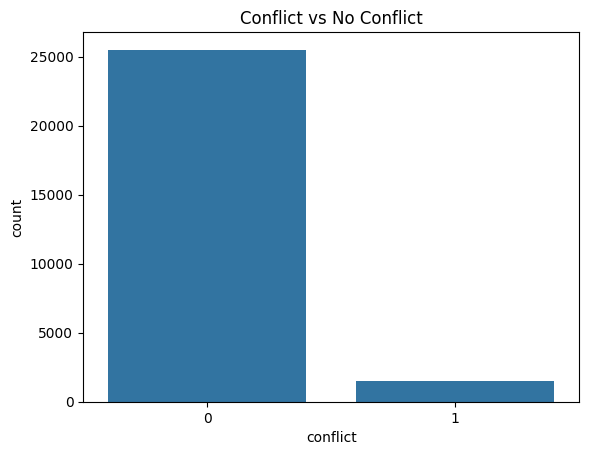

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='conflict', data=df)
plt.title('Conflict vs No Conflict')
plt.show()

### Dataset Analysis

After analyzing the target variable (`conflict`), we observe that the dataset is **highly imbalanced**:

- About **5.44%** of the samples represent **merge conflicts** (class 1).
- About **94.56%** represent **non-conflict merges** (class 0).

---

### Implications of Imbalance:

- **Training difficulty**:  
  The models may become biased toward predicting the majority class (no conflict) because it dominates the data.
  
- **Stratification necessity**:  
  When splitting the data into training and testing sets, it is important to apply **stratification**.  
  This ensures that both sets maintain the same proportion of conflict vs non-conflict samples as the original dataset.

- **Metric selection**:  
  Instead of simple accuracy (which would misleadingly be very high by always predicting "no conflict"), we focus on:
  - **F1 Score**: Balances precision and recall, more meaningful for rare class detection.
  - **PR-AUC** (Precision-Recall AUC): Specifically sensitive to performance on the rare positive class (conflicts), giving a better picture of model effectiveness.



In [61]:
df.head()

,commit,parent1,parent2,ancestor,is pr,added lines,deleted lines,devs parent1,devs parent2,time,...,add,remove,use,delete,change,messages_min,messages_max,messages_mean,messages_median,conflict
0,efc0bcd1d6199448c323549fdc45310750b48c85,fb9f2a65cabba5a924b89a45793914066471b2ab,5ee7c7c750e9ecffaea12f97d5b05b2445e7c007,fb9f2a65cabba5a924b89a45793914066471b2ab,1,5,0,0,1,23,...,0,0,0,0,0,20,65,35.40000,20.0,0
1,287b9b838b6b6b212ef538aa537aef76110ee111,72fd7d81c9c7e28af8740f5a1b210a803290383d,fb9f2a65cabba5a924b89a45793914066471b2ab,a18c1088c892f1e6ed4b7d541e68b2e4b039a42e,0,1166,11267,1,2,371,...,0,0,0,0,0,31,117,58.56383,53.5,1
2,e7478680c0db825239ea9628967728c8577bb5c2,36977963caa2896ad9a4a92b2bdcd85189beccb1,bc230857adc3a9763bc7d89793d826463c857c00,36977963caa2896ad9a4a92b2bdcd85189beccb1,1,0,0,0,1,22,...,0,0,0,0,0,18,18,18.00000,18.0,0
3,0c65b30a8fd3a7db40163fcb9b0004cb7487c0ff,419e6d2d9fb91f2d9cdbdd1161a6c7ecc329363f,877c43f8242b88447d0234400c6e9b5c7586b558,fe29962932a8e34f0c3ac5cd795cd40090c9fabd,1,0,0,2,1,24,...,0,0,0,0,0,22,63,38.80000,31.0,0
4,419e6d2d9fb91f2d9cdbdd1161a6c7ecc329363f,7899f565d3461ed287e61662c8d399aafcac9e42,5e68e04e310c4f57a19d4cfa6be1e0ba3a8801d6,236b85af833398e0f07d08b7d7a25734d8c1b11d,0,0,0,1,2,2,...,0,0,0,0,0,31,56,43.50000,43.5,1


### Removing Non-Predictive ID Columns

We remove columns such as `commit`, `parent1`, `parent2`, and `ancestor` because they act as unique identifiers rather than meaningful predictive features.

- These columns do not carry useful information for learning patterns related to merge conflicts.
- Keeping them would risk introducing noise and unnecessary complexity into the model.

After removing these columns, the dataset contains only the meaningful features needed for training.

In [62]:
# Remove ID columns as they are not useful for prediction
id_cols = ['commit', 'parent1', 'parent2', 'ancestor']
df_clean = df.drop(columns=id_cols)
df = df_clean

### Feature-Target Split and Feature Type Check

We split the dataset into:

- **X**:  
  The input features (all columns except the target `conflict`). These variables will be used to predict whether a merge conflict will occur.

- **y**:  
  The output label (`conflict`), which is a binary variable:
  - `1` → Merge conflict occurred
  - `0` → No merge conflict


In [63]:
X = df_clean.drop('conflict', axis=1)
X.head()

,is pr,added lines,deleted lines,devs parent1,devs parent2,time,nr files,added files,deleted files,renamed files,...,update,add,remove,use,delete,change,messages_min,messages_max,messages_mean,messages_median
0,1,5,0,0,1,23,0,0,0,0,...,3,0,0,0,0,0,20,65,35.40000,20.0
1,0,1166,11267,1,2,371,3,7,199,2,...,1,0,0,0,0,0,31,117,58.56383,53.5
2,1,0,0,0,1,22,0,0,0,0,...,0,0,0,0,0,0,18,18,18.00000,18.0
3,1,0,0,2,1,24,1,0,0,0,...,0,0,0,0,0,0,22,63,38.80000,31.0
4,0,0,0,1,2,2,1,0,0,0,...,0,0,0,0,0,0,31,56,43.50000,43.5


In [64]:
y = df_clean['conflict']
y.head()

0    0
1    1
2    0
3    0
4    1
Name: conflict, dtype: int64

### Numeric Feature Verification

After dropping irrelevant columns, I verify if all features are **numeric**:

- If all features are numeric, **no encoding** (e.g., one-hot encoding, label encoding) is needed before training.
- If any non-numeric features were present, we would need to apply encoding to convert them into a suitable numerical format.

In this case, all features are numeric, so we proceed directly to feature scaling and modeling.

In [65]:
if df.drop(columns=['conflict']).map(np.isreal).all().all():
    print("✅ All features are numeric. No encoding is required before training.")
else:
    print("⚠️ Some features are non-numeric. Encoding is needed.")


✅ All features are numeric. No encoding is required before training.


### Performance Measurement Choices

Given the **highly imbalanced nature** of the dataset (only ~5% of samples are actual conflicts), standard accuracy would be misleading.  
Instead, we evaluate our models based on:

- **Precision**:  
  How many predicted conflicts were actually true conflicts.  
  Important when false positives are costly.

- **Recall**:  
  How many real conflicts were correctly detected.  
  Important when missing conflicts (false negatives) is costly.

- **F1-Score**:  
  The harmonic mean of Precision and Recall, balancing the two.

- **PR-AUC (Precision-Recall Area Under Curve)**:  
  A single number summarizing model performance across all classification thresholds.  
  Especially meaningful for **imbalanced datasets**, as it focuses on the rare positive class (conflicts).

---

### Precision-Recall Curve (PRC) and PR-AUC Interpretation

After evaluating the model, we plot the **Precision-Recall Curve** to visualize the trade-off between Precision and Recall at different probability thresholds.  

- **Precision =** TP / (TP + FP) → Among predicted conflicts, how many are real.
- **Recall =** TP / (TP + FN) → Among real conflicts, how many we found.

A **higher PR-AUC** indicates a better model for detecting rare, important cases like merge conflicts.

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_recall_curve, 
    auc
)
import numpy as np

def evaluate_model(model, X_test, y_test, model_name, save_plots=False, display_curve=False):
    """
    Evaluates a classification model on the test set.
    
    Args:
        model: Trained sklearn model.
        X_test (np.ndarray or pd.DataFrame): Test features.
        y_test (np.ndarray or pd.Series): True test labels.
        model_name (str): Name of the model (for saving plots and titles).
        save_plots (bool): Whether to save the plots to disk.
        display_curve (bool): Whether to immediately display the PR curve.
    
    Returns:
        dict: Dictionary containing the trained model and classification report.
    """

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Get predicted probabilities if the model supports it (needed for PRC)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Print classification metrics (precision, recall, f1-score, etc.)
    print(f"\n{model_name} Performance:")
    print(classification_report(y_test, y_pred))
    
    # Compute and normalize the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by actual class count

    # Plot normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=['No Conflict', 'Conflict'],
                yticklabels=['No Conflict', 'Conflict'],
                cbar=False)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.title(f'Normalized Confusion Matrix - {model_name}', fontsize=14)
    
    if save_plots:
        # Save confusion matrix plot if requested
        plt.savefig(f"{model_name.replace(' ', '_')}_confusion_matrix.png", bbox_inches='tight')
    
    plt.show()
    plt.close()

    # If model outputs probabilities, calculate Precision-Recall curve and PR-AUC
    if y_pred_proba is not None:
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        print(f"PR-AUC: {pr_auc:.4f}")

        # Plot Precision-Recall Curve
        plt.figure(figsize=(7, 5))
        plt.plot(recall, precision, color='navy', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
        plt.fill_between(recall, precision, alpha=0.3, color='blue')
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title(f'Precision-Recall Curve - {model_name}', fontsize=14)
        plt.legend(loc='lower left')
        plt.grid(alpha=0.3)
        
        if save_plots:
            # Save PRC plot if requested
            plt.savefig(f"{model_name.replace(' ', '_')}_pr_curve.png", bbox_inches='tight')
        
        if display_curve:
            # Optionally display PRC immediately
            plt.show()
        
        plt.close()

    # Return the model and a dictionary version of the classification report
    return {
        'model': model,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }

### Feature Selection

To reduce model complexity and focus on the most important predictors, we apply two feature selection techniques:

---

#### 1. Correlation with Target Variable

We analyze the **correlation** between each feature and the target variable (`conflict`):

- Correlation measures the **strength and direction** of a linear relationship between features and the target.
- Features with higher absolute correlation values are more likely to be relevant for prediction.
- A **Seaborn heatmap** is used to visualize these relationships easily.

---

#### 2. Random Forest Feature Importances

We train a **Random Forest Classifier** to compute feature importances:

- Random Forests, as ensembles of Decision Trees, **naturally estimate** how important each feature is for making accurate predictions.
- Features that result in **greater impurity reduction** (e.g., Gini decrease) across many trees are considered more important.
- This method captures **both linear and non-linear relationships**, offering a broader perspective beyond simple correlation.

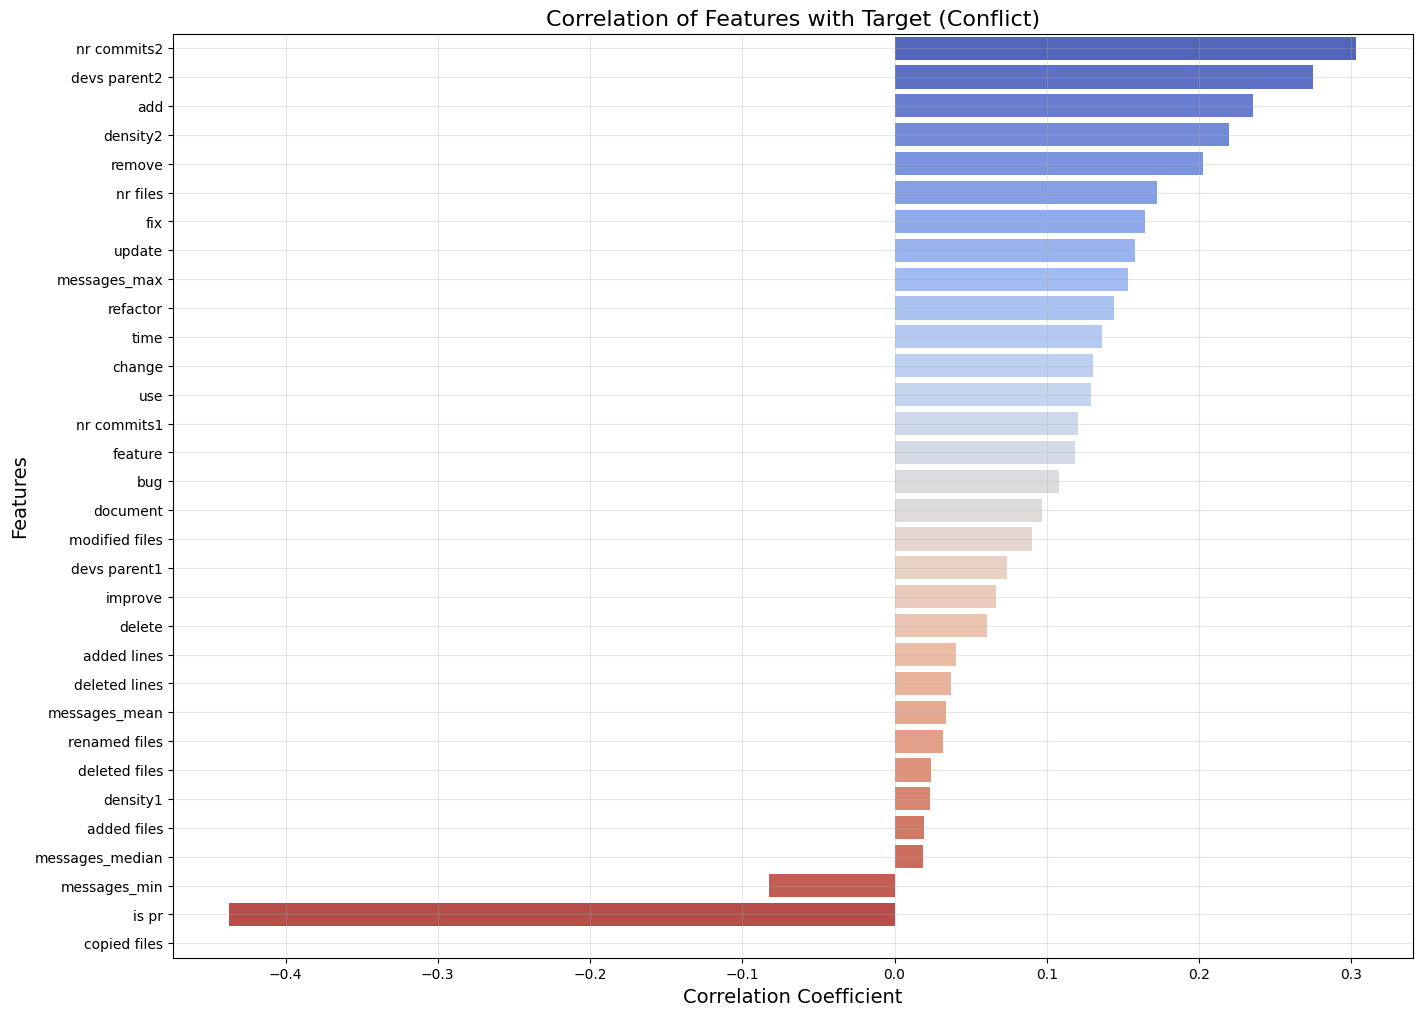

In [67]:
# 1. Correlation with Target Variable

plt.figure(figsize=(16, 12))
corr = df.corr()

# Focus only on correlation with the target, sorted
target_corr = corr['conflict'].drop('conflict').sort_values(ascending=False)

# Proper bar plot without future warnings
sns.barplot(x=target_corr.values, y=target_corr.index, hue=target_corr.index, palette='coolwarm', dodge=False, legend=False)

plt.title('Correlation of Features with Target (Conflict)', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

**Note on Feature Importance vs Correlation:**

While `is_pr` shows a negative correlation with the target variable (`conflict`),  
Random Forest ranks it as highly important.

This happens because:

- Correlation measures only direct, linear relationships between one feature and the target.
- Random Forest feature importance measures how useful a feature is at **splitting** data to improve predictive power, including non-linear interactions with other features.

Thus, even if `is_pr` has low or negative linear correlation, it can still be a very strong predictor inside tree-based models.

### Random Forest Feature Importances

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# 1. Train-Test Split (with stratification to maintain class imbalance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
# 2. Feature Scaling (important for models sensitive to scale)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
# 3. Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [71]:
# 4. Retrieve feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1] 
print("Feature Importances:", importances)

Feature Importances: [0.10808997 0.04101924 0.03230224 0.02481508 0.03402526 0.04182484
 0.22748238 0.01273035 0.00565174 0.00505453 0.         0.02661884
 0.0353209  0.04946236 0.01910685 0.01832407 0.02279168 0.00946794
 0.00682409 0.0069418  0.00741998 0.0070699  0.02184344 0.04365662
 0.01528307 0.01190273 0.00283202 0.01094077 0.03944995 0.03507806
 0.03836423 0.03830509]


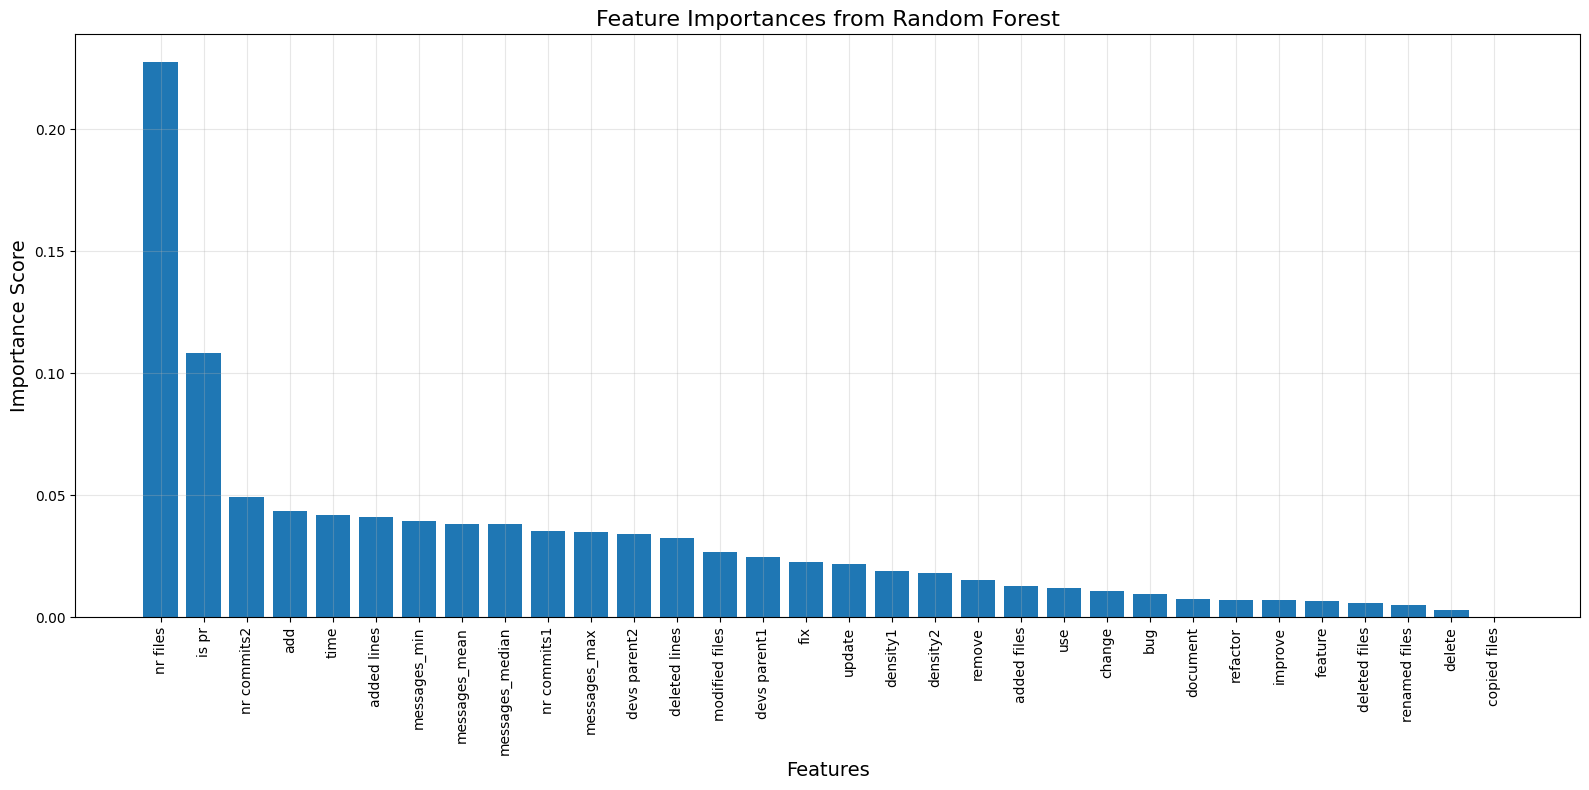

In [72]:
plt.figure(figsize=(16, 8))
plt.title("Feature Importances from Random Forest", fontsize=16)
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(X.columns)[indices], rotation=90)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Importance Score", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Feature Selection Rationale

Based on the Random Forest feature importances:

- `nr_files` had the highest importance (~25%), indicating a very strong influence on conflict prediction.
- `is_pr` followed with around 15%, a solid contribution to predictive accuracy.
- `nr_commits2` had moderate importance, but adds valuable information about developer activity.

Thus, the selected features (`nr_files`, `is_pr`, `nr_commits2`) represent a balance between model simplicity and predictive strength.

Selecting only the most influential features helps improve model generalization, reduces overfitting, and speeds up training.


In [73]:
print(df.columns.tolist())

['is pr', 'added lines', 'deleted lines', 'devs parent1', 'devs parent2', 'time', 'nr files', 'added files', 'deleted files', 'renamed files', 'copied files', 'modified files', 'nr commits1', 'nr commits2', 'density1', 'density2', 'fix', 'bug', 'feature', 'improve', 'document', 'refactor', 'update', 'add', 'remove', 'use', 'delete', 'change', 'messages_min', 'messages_max', 'messages_mean', 'messages_median', 'conflict']


### Building a Slim Dataset Based on Important Features

After identifying the most influential features (`nr files`, `is pr`, `nr commits2`),  
we extract them into a smaller dataframe.

We then apply **feature scaling** using `StandardScaler`:

- Ensures all features have mean 0 and standard deviation 1.
- Helps models (especially distance-based ones) behave more consistently.


In [20]:
### Feature Selection and Scaling

# 1. Select the top important features
X_selected = df[['nr files', 'is pr', 'nr commits2']]

# 2. Scale the selected features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# 3. Rebuild into a nice, smaller DataFrame for easier handling later
X_scaled_df = pd.DataFrame(X_scaled, columns=['nr_files', 'is_pr', 'nr_commits2'])

X_scaled_df.head()

,nr_files,is_pr,nr_commits2
0,-0.070587,0.534535,-0.016514
1,0.212291,-1.870784,1.635330
2,-0.070587,0.534535,-0.173832
3,0.023706,0.534535,-0.173832
4,0.023706,-1.870784,-0.134503


### Train-Test Split

We split the dataset into a **training set** and a **test set** using an 80-20 ratio:

- **80%** of the data (training set) is used to train and tune the models.
- **20%** of the data (test set) is kept aside to evaluate the final model performance on **unseen data**.

This ensures that:

- We **properly validate** model generalization ability.
- We avoid **overfitting** to the training data.
- We **stratify** the split to maintain the original **class imbalance** (5% conflicts, 95% non-conflicts) in both sets.

Choosing a 0.2 (20%) test size is a **common practice**, providing a good balance between having enough data for training and testing.

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (21577, 3), Test shape: (5395, 3)


### Model Training, Saving, Loading, and Evaluation Strategy

To ensure efficient and reproducible model training and assessment, I adopted the following workflow across all models (Decision Tree, Random Forest, Naive Bayes):

1. **Train the model on the training set.**  
   - For Decision Tree and Random Forest models, we use **GridSearchCV** to search for the best combination of hyperparameters (e.g., max depth, number of estimators, minimum samples to split).
   - For Naive Bayes (a simple model without hyperparameters), we train directly without tuning.


2. **Save the best trained model into a pickle (`.pkl`) file.**  
   - After training, the model is serialized and saved locally.
   - This ensures that models do not need to be retrained on every notebook run.


3. **Load the model from the pickle file if it already exists.**  
   - Before training, we check if the `.pkl` file exists.
   - If found, we directly load the cached model to save computational time.
   - Otherwise, the model is trained and saved.


4. **Evaluate the model on the test set.**  
   - After training (or loading), every model is evaluated using:
     - Precision
     - Recall
     - F1-Score
     - PR-AUC (Precision-Recall Area Under Curve)
   - We also generate visualizations such as:
     - Normalized confusion matrices
     - Precision-Recall curves

### Decision Tree Classifier Model

A **Decision Tree Classifier** is a simple yet powerful machine learning model that works by:

- Splitting the dataset into smaller and smaller groups based on feature thresholds.
- Building a tree-like structure where each internal node represents a decision based on a feature.
- Leaf nodes represent the final prediction (conflict or no conflict).

#### Workflow for Decision Tree:

1. **Hyperparameter Optimization**:  
   We tune the maximum tree depth (`max_depth`) and minimum samples required for a split (`min_samples_split`) using `GridSearchCV`, optimizing for **F1 score**.
   
2. **Training**:  
   We train the best Decision Tree on the training data.

3. **Saving the Model**:  
   We save the trained model to disk using `pickle` so that we can reuse it later without retraining.

4. **Evaluation**:  
   We evaluate the model using Precision, Recall, F1-Score, and PR-AUC metrics, important especially because of the **class imbalance** 

In [75]:
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

model_path_decision_tree = "best_decision_tree.pkl"

In [76]:
def train_and_save_decision_tree(X_train, y_train, model_path):
    """
    Trains a Decision Tree with GridSearchCV and saves the best model to a pickle file.

    Args:
        X_train (np.ndarray or pd.DataFrame): Training features.
        y_train (np.ndarray or pd.Series): Training labels.
        model_path (str): Path where the trained model will be saved.

    Returns:
        best_tree (DecisionTreeClassifier): The best trained Decision Tree model.
    """
    tree = DecisionTreeClassifier(random_state=42)

    param_grid = {
        'max_depth': [2, 4, 6, 8, 10],
        'min_samples_split': [2, 5, 10]
    }

    grid_tree = GridSearchCV(tree, param_grid, scoring='f1', cv=5)
    grid_tree.fit(X_train, y_train)

    best_tree = grid_tree.best_estimator_

    with open(model_path, 'wb') as f:
        pickle.dump(best_tree, f)

    print("Trained and saved Decision Tree model to pickle.")
    print("Best parameters:", grid_tree.best_params_)
    print("Best cross-validation F1 score:", grid_tree.best_score_)

    return best_tree

Loaded Decision Tree model from pickle.

Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5101
           1       0.68      0.62      0.65       294

    accuracy                           0.96      5395
   macro avg       0.83      0.80      0.81      5395
weighted avg       0.96      0.96      0.96      5395



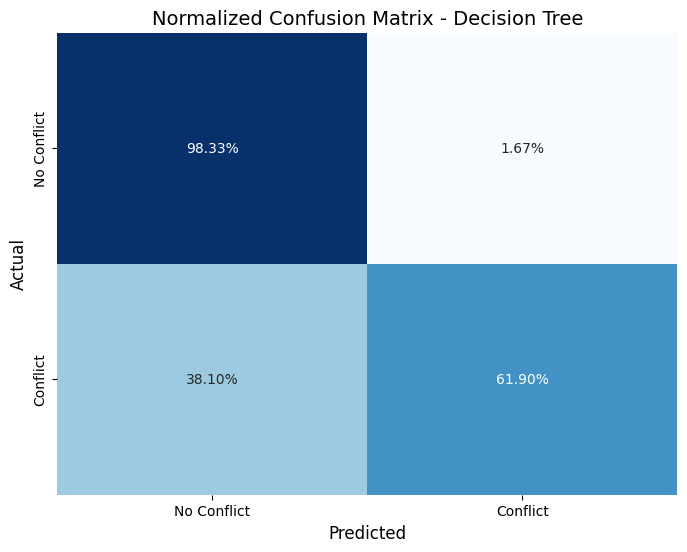

PR-AUC: 0.6782


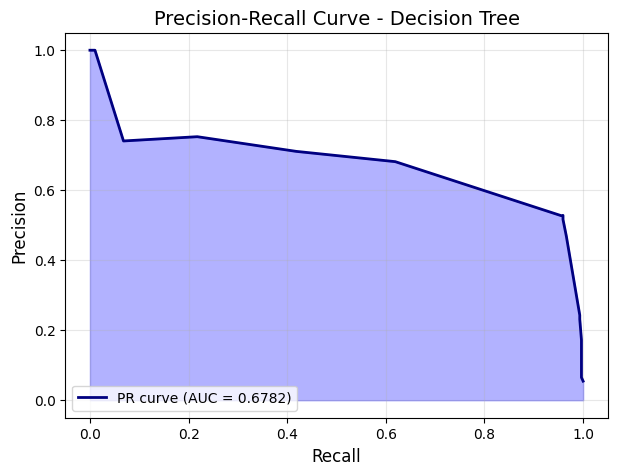

In [77]:
# Evalue either the newly trained model or the existing one from pickle

if os.path.exists(model_path_decision_tree):
    with open(model_path_decision_tree, 'rb') as f:
        best_tree = pickle.load(f)
    print("Loaded Decision Tree model from pickle.")
else:
    best_tree = train_and_save_decision_tree(X_train, y_train, model_path_decision_tree)

results_tree = evaluate_model(best_tree, X_test, y_test, model_name="Decision Tree", save_plots=True, display_curve=True)

### Displaying the Decision Tree and PR Curve

In this step and the one above, I allowed the **Precision-Recall Curve** to be displayed inline (`display_curve=True`) for easier immediate analysis and to make it visually understanding to the reader what its purpose is.
For visual purposes, we also plot the trained **Decision Tree** directly.  


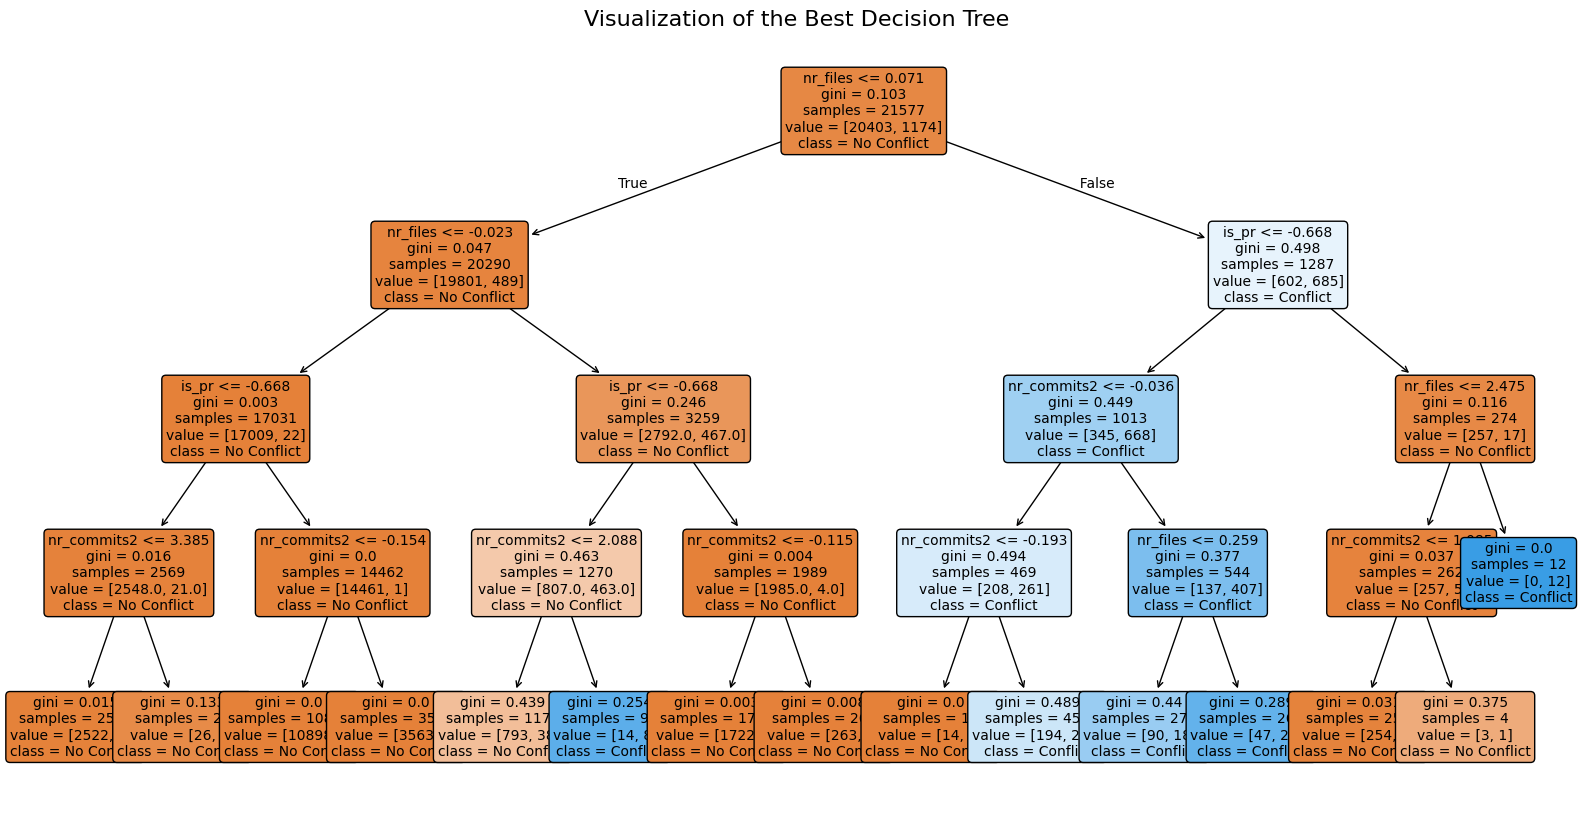

In [78]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))  
plot_tree(best_tree, 
          feature_names=['nr_files', 'is_pr', 'nr_commits2'], 
          class_names=['No Conflict', 'Conflict'], 
          filled=True, rounded=True, fontsize=10)
plt.title("Visualization of the Best Decision Tree", fontsize=16)
plt.show()

### Naive Bayes Model

A **Naive Bayes Classifier** is an even simpler and faster probabilistic machine learning model based on **Bayes' Theorem**:

- It assumes that all features are **independent** of each other given the target class ("naive" assumption).
- The model calculates the **probability** that a sample belongs to each class and predicts the class with the highest probability.
- It is particularly effective for small datasets and works well even with highly imbalanced classes.


In [79]:
from sklearn.naive_bayes import GaussianNB

nb_model_path = "naive_bayes_model.pkl"

In [80]:
def train_and_save_naive_bayes(X_train, y_train, model_path):
    """
    Trains a Gaussian Naive Bayes model and saves it to a pickle file.

    Args:
        X_train (np.ndarray or pd.DataFrame): Training features.
        y_train (np.ndarray or pd.Series): Training labels.
        model_path (str): Path where the trained model will be saved.

    Returns:
        nb_model (GaussianNB): The trained Naive Bayes model.
    """
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)

    with open(model_path, 'wb') as f:
        pickle.dump(nb_model, f)

    print("Trained and saved Naive Bayes model to pickle.")
    return nb_model

Loaded Naive Bayes model from pickle.

Naive Bayes Performance:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5101
           1       0.61      0.32      0.42       294

    accuracy                           0.95      5395
   macro avg       0.79      0.66      0.70      5395
weighted avg       0.94      0.95      0.94      5395



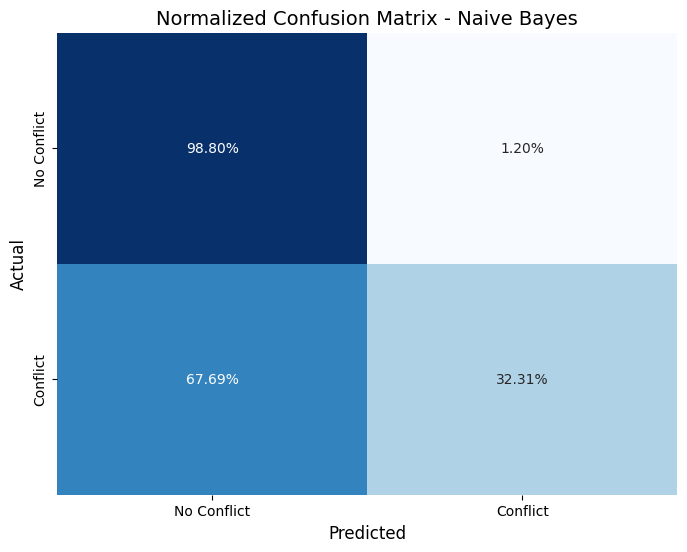

PR-AUC: 0.5643


In [81]:
if os.path.exists(nb_model_path):
    with open(nb_model_path, 'rb') as f:
        nb_model = pickle.load(f)
    print("Loaded Naive Bayes model from pickle.")
else:
    nb_model = train_and_save_naive_bayes(X_train, y_train, nb_model_path)

results_nb = evaluate_model(nb_model, X_test, y_test, model_name="Naive Bayes", save_plots=True)

### Random Forest Classifier Model

A **Random Forest Classifier** is an ensemble machine learning model that combines the predictions of multiple Decision Trees to produce more robust and accurate results:

- Each individual tree is trained on a **random subset** of the data (with replacement — a technique called bagging).
- At each node, only a **random subset of features** is considered for splitting, introducing further diversity between trees.
- The final prediction is made by **aggregating the predictions** of all trees (majority vote for classification).

**Advantages of Random Forest**:
- **Reduces overfitting** compared to a single Decision Tree.
- **Handles feature importance** naturally, allowing us to identify which features are most predictive.
- **Performs well** even with imbalanced datasets and noisy data.

#### Random Forest Training Workflow
1. **Hyperparameter Tuning**: We optimize `n_estimators`, `max_depth`, and `min_samples_split` using `GridSearchCV` based on F1 score.
2. **Training and Saving**: We train the best Random Forest model and save it to disk using `pickle`.
3. **Evaluation**: We evaluate the model on the test set using Precision, Recall, F1-score, and PR-AUC metrics.

In [82]:
from sklearn.ensemble import RandomForestClassifier

rf_model_path = "random_forest_model.pkl"

In [83]:
def train_and_save_random_forest(X_train, y_train, model_path):
    """
    Trains a Random Forest with GridSearchCV and saves the best model to a pickle file.

    Args:
        X_train (np.ndarray or pd.DataFrame): Training features.
        y_train (np.ndarray or pd.Series): Training labels.
        model_path (str): Path where the trained model will be saved.

    Returns:
        best_rf (RandomForestClassifier): The best trained Random Forest model.
    """
    rf = RandomForestClassifier(random_state=42)

    param_grid_rf = {
        'n_estimators': [50, 100, 200],
        'max_depth': [4, 6, 8, 10],
        'min_samples_split': [2, 5, 10]
    }

    grid_rf = GridSearchCV(rf, param_grid_rf, scoring='f1', cv=5)
    grid_rf.fit(X_train, y_train)

    best_rf = grid_rf.best_estimator_

    with open(model_path, 'wb') as f:
        pickle.dump(best_rf, f)

    print("Trained and saved Random Forest model to pickle.")
    print("Best Random Forest parameters:", grid_rf.best_params_)
    print("Best Random Forest cross-validation F1 score:", grid_rf.best_score_)

    return best_rf

Loaded Random Forest model from pickle.

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5101
           1       0.67      0.57      0.62       294

    accuracy                           0.96      5395
   macro avg       0.82      0.78      0.80      5395
weighted avg       0.96      0.96      0.96      5395



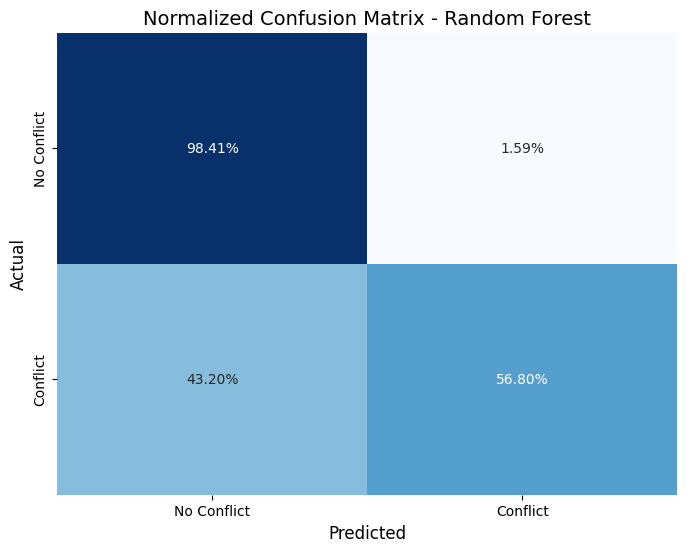

PR-AUC: 0.6789


In [84]:
if os.path.exists(rf_model_path):
    with open(rf_model_path, 'rb') as f:
        best_rf = pickle.load(f)
    print("Loaded Random Forest model from pickle.")
else:
    best_rf = train_and_save_random_forest(X_train, y_train, rf_model_path)

results_rf = evaluate_model(best_rf, X_test, y_test, model_name="Random Forest", save_plots=True)

### Model Performances Overview

| Model          | Test F1-Score | Test PR-AUC | Notes                                           |
|----------------|---------------|-------------|-------------------------------------------------|
| Decision Tree  | 0.65          | 0.6782      | Good balance, slight overfitting avoided by depth control |
| Naive Bayes    | 0.42          | 0.5643      | Very simple model, struggles on complex patterns |
| Random Forest  | 0.62          | 0.6789      | More robust, ensemble of trees improves generalization; accuracy: 96%, F1-weighted: 0.96 |


### New Features Implementation

To improve model performance and capture deeper relationships in the data, we engineered three new features based on the existing ones:

- **Commit Ratio**: Ratio between the number of commits on parent1 and parent2. A strong imbalance could signal higher risk of conflict.
- **Added to Deleted Lines Ratio**: Ratio of added lines to deleted lines. Imbalanced code modifications might suggest chaotic development, leading to conflicts.
- **Commit Message Length Range**: Difference between the longest and shortest commit messages in a branch. A large range might indicate inconsistencies in code practices across commits.

In [85]:
# Commit Ratio: number of commits parent1 / (number of commits parent2 + 1)
df['commit_ratio'] = df['nr commits1'] / (df['nr commits2'] + 1)

# Added to Deleted Lines Ratio: added lines / (deleted lines + 1)
df['added_deleted_ratio'] = df['added lines'] / (df['deleted lines'] + 1)

# Commit Message Length Range: difference between max and min commit message lengths
df['commit_message_range'] = df['messages_max'] - df['messages_min']

# Display the new features
df[['commit_ratio', 'added_deleted_ratio', 'commit_message_range']].head()

# Note: We add +1 such that we do not divide by 0

,commit_ratio,added_deleted_ratio,commit_message_range
0,0.000000,5.000000,45
1,0.041667,0.103479,86
2,0.000000,0.000000,0
3,2.500000,0.000000,41
4,0.333333,0.000000,25


### Model Retraining with New Features

After engineering new features (`commit_ratio`, `added_deleted_ratio`, `commit_message_range`),  
we extend our dataset and **retrain the models** to see if the extra information improves performance.

---

### Extended Workflow:

1. **Feature Selection**:  
   We now select the original important features (`nr files`, `is pr`, `nr commits2`) **plus** the new engineered ones.

2. **Feature Scaling**:  
   We apply `StandardScaler` to normalize the features to mean 0 and standard deviation 1, ensuring that features are on the same scale.

3. **Train-Test Split**:  
   The data is split into **80% training** and **20% testing**, stratifying by the conflict label to preserve class distribution.

4. **Model Loading or Training**:  
   We introduce a flexible system:
   - If a trained model already exists (saved via `pickle`), we **load** it to save time.
   - Otherwise, we **train** a new model using the same logic as before (with hyperparameter tuning if needed), and then **cache** it for future runs.


In [86]:
# Select features including the new engineered ones
X_selected_extended = df[['nr files', 'is pr', 'nr commits2', 'commit_ratio', 'added_deleted_ratio', 'commit_message_range']]

# Scaling
scaler = StandardScaler()
X_scaled_ext = scaler.fit_transform(X_selected_extended)

X_scaled_ext_df = pd.DataFrame(X_scaled_ext, columns=['nr files', 'is pr', 'nr commits2', 'commit_ratio', 'added_deleted_ratio', 'commit_message_range'])

# Train/test split
X_train_ext, X_test_ext, y_train_ext, y_test_ext = train_test_split(
    X_scaled_ext_df, y, test_size=0.2, random_state=42, stratify=y
)

In [87]:
def load_or_train_model(model_path, train_function, X_train, y_train):
    """
    Loads a model from pickle if available, otherwise trains and saves it.

    Args:
        model_path (str): Path to the pickle file.
        train_function (callable): Function to train the model if not found.
        X_train (array): Training features.
        y_train (array): Training labels.

    Returns:
        model: The loaded or trained model.
    """
    if os.path.exists(model_path):
        print(f"Loading cached model from {model_path}")
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
    else:
        print(f"No cached model found at {model_path}. Training a new one...")
        model = train_function(X_train, y_train, model_path)
    
    return model

In [88]:
model_paths = {
    "decision_tree": "best_decision_tree_extended.pkl",
    "naive_bayes": "naive_bayes_extended.pkl",
    "random_forest": "best_random_forest_extended.pkl"
}

Loading cached model from best_decision_tree_extended.pkl

Decision Tree Extended Performance:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5101
           1       0.68      0.62      0.65       294

    accuracy                           0.96      5395
   macro avg       0.83      0.80      0.81      5395
weighted avg       0.96      0.96      0.96      5395



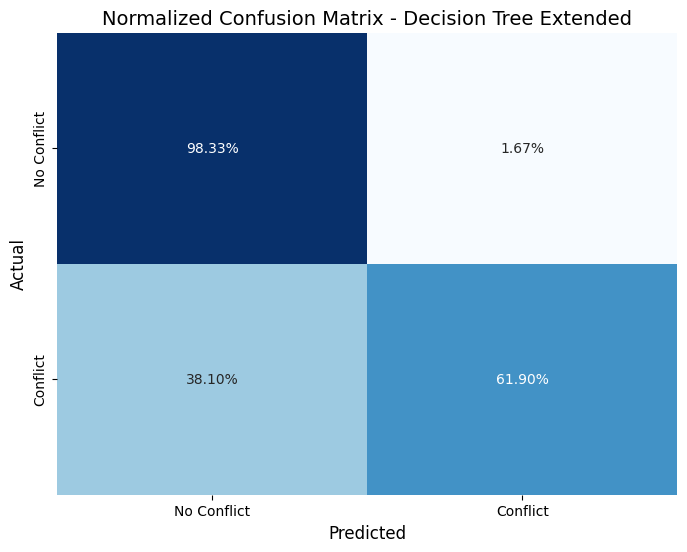

PR-AUC: 0.6801


In [89]:
# Train, save, and evaluate Decision Tree
best_tree_ext = load_or_train_model(model_paths["decision_tree"], train_and_save_decision_tree, X_train_ext, y_train_ext)
results_tree_ext = evaluate_model(best_tree_ext, X_test_ext, y_test_ext, model_name="Decision Tree Extended", save_plots=True)

Loading cached model from naive_bayes_extended.pkl

Naive Bayes Extended Performance:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5101
           1       0.52      0.39      0.45       294

    accuracy                           0.95      5395
   macro avg       0.74      0.69      0.71      5395
weighted avg       0.94      0.95      0.94      5395



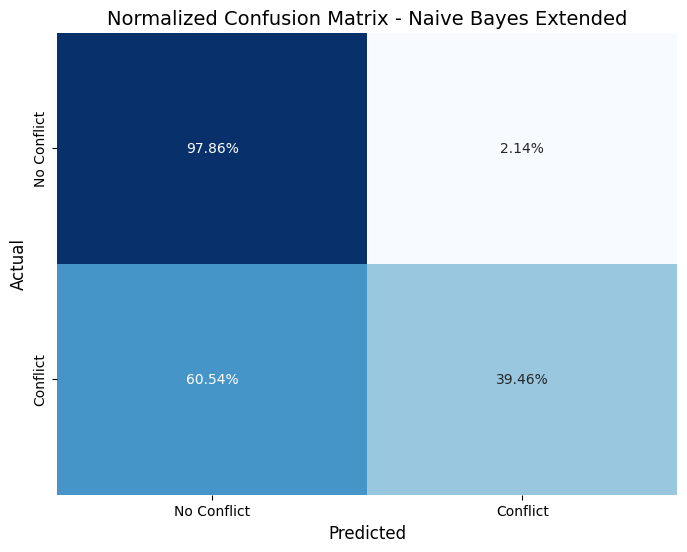

PR-AUC: 0.4930


In [90]:
# Train, save, and evaluate Naive Bayes
nb_model_ext = load_or_train_model(model_paths["naive_bayes"], train_and_save_naive_bayes, X_train_ext, y_train_ext)
results_nb_ext = evaluate_model(nb_model_ext, X_test_ext, y_test_ext, model_name="Naive Bayes Extended", save_plots=True)

Loading cached model from best_random_forest_extended.pkl

Random Forest Extended Performance:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5101
           1       0.69      0.57      0.63       294

    accuracy                           0.96      5395
   macro avg       0.83      0.78      0.80      5395
weighted avg       0.96      0.96      0.96      5395



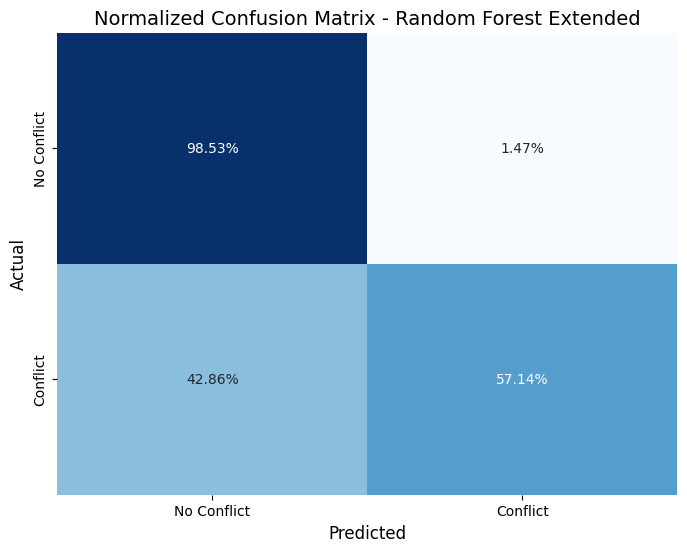

PR-AUC: 0.7410


In [91]:
# Train, save, and Random Forest
best_rf_ext = load_or_train_model(model_paths["random_forest"], train_and_save_random_forest, X_train_ext, y_train_ext)
results_rf_ext = evaluate_model(best_rf_ext, X_test_ext, y_test_ext, model_name="Random Forest Extended", save_plots=True)

### Model Performances Overview (After Adding New Features)


| Model                  | Test F1-Score | Test PR-AUC | Notes                                               |
|-------------------------|---------------|-------------|-----------------------------------------------------|
| Decision Tree Extended  | 0.65           | 0.6782      | Absolultely no changes have been made. |
| Naive Bayes Extended    | 0.45           | 0.4930      | Slight improvement (+7.14% F1, -12.63% PR-AUC); still struggles. |
| Random Forest Extended  | 0.63           | 0.7410      | Improved (+1.61% F1, +9.17% PR-AUC); ensemble remains strong. |


### Conclusion

Feature engineering led to a slight improvement in overall model performance:

- Random Forest saw a meaningful PR-AUC boost (+9.17%), confirming its robustness with deeper features.
- Naive Bayes improved in F1 but slightly worsened in PR-AUC, reflecting its limitations on more complex patterns.
- Decision Tree maintained similar performance, maintaining interpretability.

Overall, engineered features like commit ratios and message length ranges provided valuable extra information for better conflict prediction.

